In [0]:
# Load libraries

#import seaborn as sns
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler


In [2]:
# Load dataset
from google.colab import drive
drive.mount('/content/gdrive')

filename = 'df_highway_2012_4mon_sample.h5'

df_LA = pd.read_hdf('/content/gdrive/My Drive/NNDL-data/' + filename)



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
#fdr_tt['measurement_tstamp'] = pd.to_datetime(fdr_tt['measurement_tstamp'])
df_LA.dtypes
df_LA.shape


(34272, 207)

## Visualization

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa8e7f56ef0>,
      dtype=object)

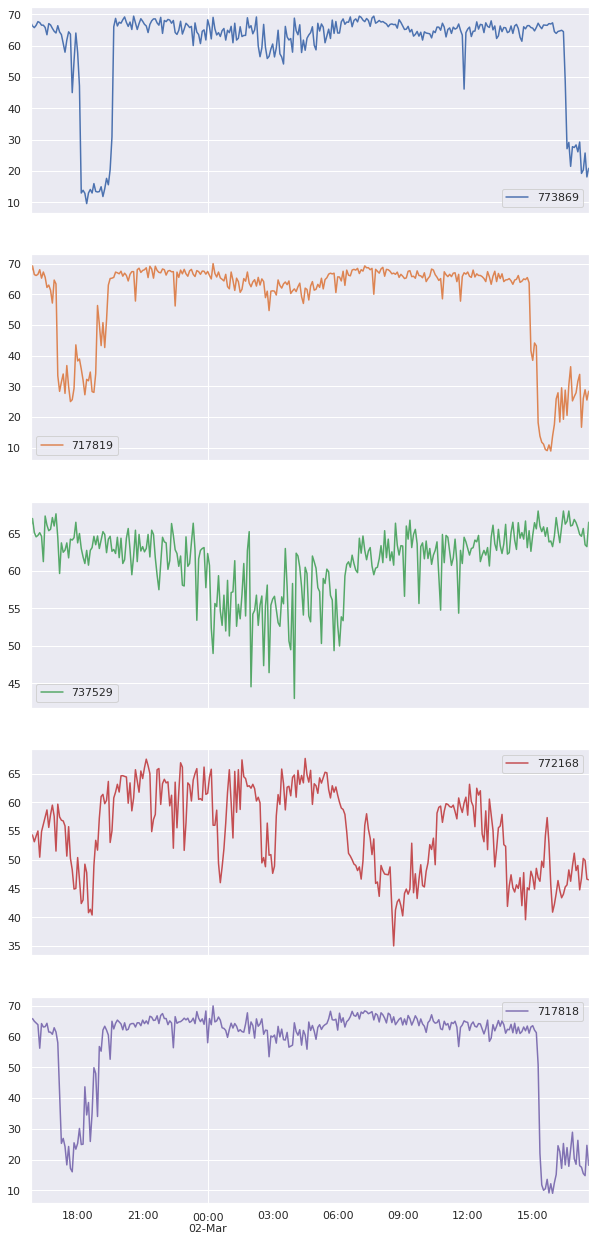

In [17]:
# Multi-series plot
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(15, 4)})

fig, axes = plt.subplots(5,1, figsize=(10,22), sharex=True)
df_LA.iloc[190:500][['773869', '717819','737529','772168','717818']].plot(subplots=True, ax=axes)

<Figure size 432x288 with 0 Axes>

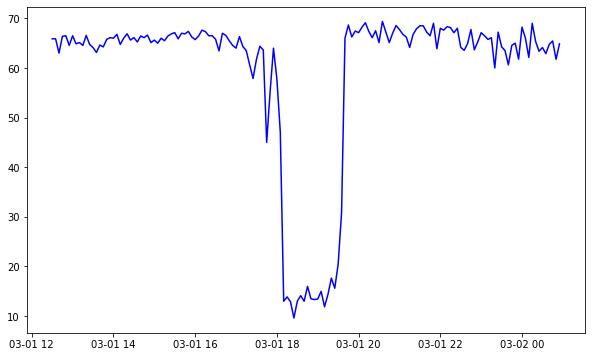

In [56]:
plt.figure()
plt.figure(figsize=(10,6))

link = 96
plt.plot(df_LA.iloc[150:300][['773869']], 'b')


plt.show()

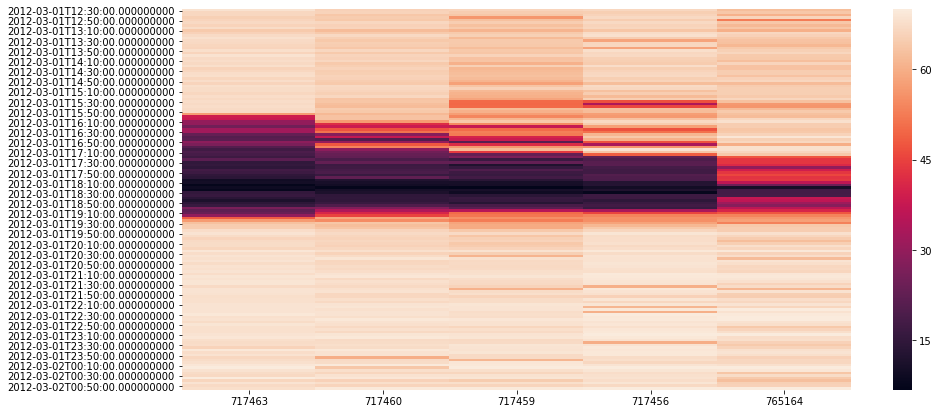

In [61]:
# Heat map
import seaborn as sns
plt.rcParams['figure.figsize'] = (15.0, 7.0)
#plt.rcParams['font.family'] = "serif"

sns.heatmap(df_LA.iloc[150:300][['717463', '717460','717459','717456','765164']])

In [0]:
717463
717460
717459
717456
765164

<Figure size 432x288 with 0 Axes>

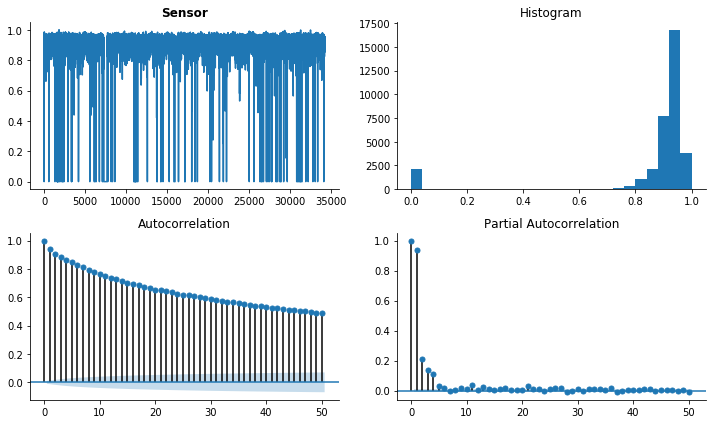

(<matplotlib.axes._subplots.AxesSubplot at 0x7f3a15fd6f28>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3a15f2e198>)

In [37]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()

def tsplot_np(y, title, lags=None, figsize=(10, 6)):
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    ts_ax.plot(y)
    ts_ax.set_title(title, fontsize=12, fontweight='bold')
    hist_ax.hist(y, bins=25)
    hist_ax.set_title('Histogram')
    sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax)
    sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax)
    sns.despine()
    plt.tight_layout()
    plt.show()
    return ts_ax, acf_ax, pacf_ax


tsplot_np(spd_mat[:,1],'Sensor',50)

## Data Normalization

In [11]:

spd_mat = df_LA.to_numpy()

print(spd_mat.shape)

spd_scaler = MinMaxScaler(feature_range=(0, 1))
spd_mat = spd_scaler.fit_transform(spd_mat)

#spd_std_scaler = StandardScaler(with_mean=True, with_std=True)
#spd_mat = spd_std_scaler.fit_transform(spd_mat)

n_out = spd_mat.shape[-1]


(34272, 207)


### Stationarity test

In [7]:
# Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

i = 200 # sensor index
dftest = adfuller(spd_mat[:,i], autolag='AIC')
dfoutput = pd.Series(dftest[0:4],
                      index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)
# if p-value is close to 0 then series is stationary

Test Statistic                -1.457574e+01
p-value                        4.552138e-27
#Lags Used                     2.200000e+01
Number of Observations Used    3.424900e+04
Critical Value (1%)           -3.430541e+00
Critical Value (5%)           -2.861624e+00
Critical Value (10%)          -2.566815e+00
dtype: float64


## Data Generators

In [0]:

# This generator function is modified from Chollet (2018), Deep Learning with Python

def generator_mat(data, lag, ahead, min_ind, max_ind, shuffle=False, batch_size=128, step=1):
    if max_ind is None:
        max_ind = len(data) - ahead - 1
    i = min_ind + lag
    while 1:
        if shuffle:
            rows = np.random.randint(min_ind+lag, max_ind, size=batch_size)
        else:
            if i+batch_size >= max_ind:
                i=min_ind+lag
            rows = np.arange(i,min(i+batch_size, max_ind))
            i += len(rows)
        
        # change to following for multivar (>1 columns)
        samples = np.zeros((len(rows),lag//step, data.shape[-1]))
        targets = np.zeros((len(rows),data.shape[-1]))
        
        for j, row in enumerate(rows):
            indices = range(rows[j]-lag, rows[j], step)
            samples[j]= data[indices]
            targets[j] = data[rows[j] + ahead][:] #index of output vectors
            
        yield samples, targets

In [0]:
# Setting data generation parameters

lag = 3 # lag of 15 minutes
step = 1 # this is a potential parameter to be optimized
ahead = 3 # 3, 6, 12 to be used - predicting 15, 30, 60-min into the future
batch_size = 128



In [0]:
# 119 days total
# 70% -> 83 days for training = 23904 obs
# 20% -> 23 days for valid
# Rest -> test
23*24*12 + 23904

30528

In [0]:
gen_tr = generator_mat(spd_mat,lag=lag,ahead=ahead,
                   min_ind=0,max_ind=23904,shuffle=False,step=step,batch_size=batch_size)
gen_val = generator_mat(spd_mat,lag=lag,ahead=ahead,
                   min_ind=23905,max_ind=30528,step=step,batch_size=batch_size)
gen_tes = generator_mat(spd_mat,lag=lag,ahead=ahead,
                   min_ind=30529,max_ind=None,step=step,batch_size=batch_size)
val_steps = (30528 - 23905 - lag) // batch_size
test_steps = (34272 - 30529 - lag) // batch_size

## Baseline Models

In [40]:
# Simple baseline model
def prev_week_val():
    error_mae = []
    for step in range(val_steps):
        samples, targets = next(gen_val)
        preds = samples[:,-1,:]
        # univariate
        #preds = samples[:,-1]
        mae = np.mean(np.abs(preds-targets))
        error_mae.append(mae)
    print(np.mean(error_mae))

prev_week_val()


0.06417778790918481


In [44]:
# Baseline model for Vector Auto-Regression (VAR) time series model

from statsmodels.tsa.vector_ar.var_model import VAR

def eval_var(traffic_reading_df, n_lags=3):
    n_forwards = [1, 3, 6, 12]
    y_predicts, y_test = var_predict(traffic_reading_df, n_forwards = n_forwards,n_lags=n_lags,
                                     test_ratio=0.3)
    for i, horizon in enumerate(n_forwards):
        mae = np.mean(np.abs(y_predicts-y_test))        
        line = 'VAR\t%d\t%.2f' % (horizon, mae)
        print(line)
        
def var_predict(df, n_forwards=(1, 3), n_lags=4, test_ratio=0.2):
    """
    Multivariate time series forecasting using Vector Auto-Regressive Model.
    :param df: pandas.DataFrame, index: time, columns: sensor id, content: data.
    :param n_forwards: a tuple of horizons.
    :param n_lags: the order of the VAR model.
    :param test_ratio:
    :return: [list of prediction in different horizon], dt_test
    """
    n_sample, n_output = df.shape
    n_test = int(round(n_sample * test_ratio))
    n_train = n_sample - n_test
    df_train, df_test = df[:n_train], df[n_train:]

    #scaler = StandardScaler(with_mean=True, with_std=True)
    #data = scaler.fit_transform(df_train)
    data = df_train
    var_model = VAR(data)
    var_result = var_model.fit(n_lags)
    max_n_forwards = np.max(n_forwards)
    
    # Do forecasting.
    result = np.zeros(shape=(len(n_forwards), n_test, n_output))
    start = n_train - n_lags - max_n_forwards + 1
    
    for input_ind in range(start, n_sample - n_lags):
#        prediction = var_result.forecast(scaler.transform(df[input_ind: input_ind + n_lags]), max_n_forwards)
        prediction = var_result.forecast(df[input_ind: input_ind + n_lags], max_n_forwards)
        for i, n_forward in enumerate(n_forwards):
            result_ind = input_ind - n_train + n_lags + n_forward - 1
            #print(result_ind)
            if 0 <= result_ind < n_test:
                result[i, result_ind, :] = prediction[n_forward - 1, :]
    
    df_predicts = []
    for i, n_forward in enumerate(n_forwards):
#        df_predicts = scaler.inverse_transform(result[i])
        df_predicts = result[i]
    return df_predicts, df_test
  
eval_var(spd_mat)

VAR	1	0.12
VAR	3	0.12
VAR	6	0.12
VAR	12	0.12


## Simple Architectures

In [45]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()

model.add(layers.Flatten(input_shape=(lag // step, spd_mat.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(n_out))
model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(gen_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_val,
                              validation_steps=val_steps)
model.save('/content/gdrive/My Drive/NNDL-project/fnn_2_layer_64_Std_3step_full.h5')

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 621)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 32)                19904     
_________________________________________________________________
dense_19 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_20 (Dense)             (None, 207)               13455     
Total params: 35,471
Trainable params: 35,471
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 4s 9ms/step - loss: 0.1518 - val_loss: 0.1293
Epoch 2/40
500/500 [==============================] - 2s 5ms/step - loss: 0.1179 - val_loss: 0.1409
Epoch 3/40
500/500 [===========================

In [9]:
# Single layer RNN: GRU 
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(64,
                     input_shape=(None, spd_mat.shape[-1])))
model.add(layers.Dense(n_out))
model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(gen_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_val,
                              validation_steps=val_steps)
model.save('/content/gdrive/My Drive/NNDL-project/gru_1_layer_simple_64_3step_full.h5')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 64)                52224     
_________________________________________________________________
dense_1 (Dense)              (None, 207)               13455     
Total params: 65,679
Trainable params: 65,679
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 7s 14ms/step - loss: 0.1157 - val_loss: 0.1081
Epoch 2/40
500/500 [==============================] - 6s 11ms/step - loss: 0.0986 - val_loss: 0.1116
Epoch 3/40
500/500 [==============================] - 5s 11ms/step - loss: 0.0947 - val_loss: 0.0964
Epoch 4/40
500/500 [==============================] - 5s 11ms/step - loss: 0.0919 - val_loss: 0.0974
Epoch 5/40
500/500 [==============================] - 5s 11ms/step - loss: 0.0911 - val_loss: 0.1003
Epoch 6

In [48]:
# Single layer RNN: GRU 
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(128,
                     input_shape=(None, spd_mat.shape[-1])))
model.add(layers.Dense(n_out))
model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(gen_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_val,
                              validation_steps=val_steps)
model.save('/content/gdrive/My Drive/NNDL-project/gru_1_layer_simple_128_Std_3step_full.h5')

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_11 (GRU)                 (None, 128)               129024    
_________________________________________________________________
dense_23 (Dense)             (None, 207)               26703     
Total params: 155,727
Trainable params: 155,727
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 7s 15ms/step - loss: 0.1168 - val_loss: 0.1077
Epoch 2/40
500/500 [==============================] - 4s 9ms/step - loss: 0.0995 - val_loss: 0.1196
Epoch 3/40
500/500 [==============================] - 4s 8ms/step - loss: 0.0939 - val_loss: 0.0965
Epoch 4/40
500/500 [==============================] - 4s 8ms/step - loss: 0.0916 - val_loss: 0.1014
Epoch 5/40
500/500 [==============================] - 4s 8ms/step - loss: 0.0883 - val_loss: 0.1130
Epoch 6/

In [0]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss for 1 Layer GRU 64 units w/ Dropout')
plt.legend()

plt.show()

In [0]:
# Single layer RNN: GRU w/ SGD + momentum 

from keras.models import Sequential
from keras import layers
from keras.optimizers import SGD

model = Sequential()
model.add(layers.GRU(64,
                     input_shape=(None, spd_mat.shape[-1])))
model.add(layers.Dense(n_out))

model.summary()
model.compile(optimizer=SGD(momentum=0.9,lr=0.001), loss='mae')
history = model.fit_generator(gen_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_val,
                              validation_steps=val_steps)
model.save('/content/gdrive/My Drive/NNDL-project/gru_1_layer_64_sgd.h5')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 64)                18624     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
Total params: 20,704
Trainable params: 20,704
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 5s 9ms/step - loss: 0.2292 - val_loss: 0.1259
Epoch 2/40
500/500 [==============================] - 4s 7ms/step - loss: 0.1156 - val_loss: 0.1193
Epoch 3/40
500/500 [==============================] - 4s 8ms/step - loss: 0.1078 - val_loss: 0.1139
Epoch 4/40
500/500 [==============================] - 4s 7ms/step - loss: 0.1037 - val_loss: 0.1103
Epoch 5/40
500/500 [==============================] - 4s 8ms/step - loss: 0.1013 - val_loss: 0.1076
Epoch 6/40
5

OSError: ignored

In [34]:
# LSTM 
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.LSTM(64,
                     input_shape=(None, spd_mat.shape[-1])))
model.add(layers.Dense(n_out))

model.summary()
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(gen_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_val,
                              validation_steps=val_steps)
model.save('/content/gdrive/My Drive/NNDL-project/lstm_1_layer_64_Std_3step_full.h5')

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                69632     
_________________________________________________________________
dense_16 (Dense)             (None, 207)               13455     
Total params: 83,087
Trainable params: 83,087
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 7s 13ms/step - loss: 0.1248 - val_loss: 0.1242
Epoch 2/40
500/500 [==============================] - 4s 9ms/step - loss: 0.1079 - val_loss: 0.1280
Epoch 3/40
500/500 [==============================] - 4s 9ms/step - loss: 0.1030 - val_loss: 0.1199
Epoch 4/40
500/500 [==============================] - 5s 10ms/step - loss: 0.0999 - val_loss: 0.1188
Epoch 5/40
500/500 [==============================] - 4s 9ms/step - loss: 0.0997 - val_loss: 0.1227
Epoch 6/4

## Deeper Architecture

In [63]:
# Stacked GRU Model - for deeper architecture
# 2 layer 64/64 units

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(64,
                     return_sequences=True,
                     input_shape=(None, spd_mat.shape[-1])))
model.add(layers.GRU(64, activation='relu'))
model.add(layers.Dense(n_out))

model.compile(optimizer=RMSprop(decay=0.001), loss='mae')
model.summary()


Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_40 (GRU)                 (None, None, 64)          52224     
_________________________________________________________________
gru_41 (GRU)                 (None, 64)                24768     
_________________________________________________________________
dense_38 (Dense)             (None, 207)               13455     
Total params: 90,447
Trainable params: 90,447
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Stacked GRU Model - for deeper architecture
# 2 layer 128/64 units

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(128,
                     return_sequences=True,
                     input_shape=(None, spd_mat.shape[-1])))
model.add(layers.GRU(64, activation='relu'))
model.add(layers.Dense(n_out))

model.compile(optimizer=RMSprop(decay=0.001), loss='mae')
model.summary()
history = model.fit_generator(gen_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_val,
                              validation_steps=val_steps)
model.save('/content/gdrive/My Drive/NNDL-project/gru_2_layer_128_64_Std_3step_full.h5')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, None, 128)         129024    
_________________________________________________________________
gru_4 (GRU)                  (None, 64)                37056     
_________________________________________________________________
dense_2 (Dense)              (None, 207)               13455     
Total params: 179,535
Trainable params: 179,535
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/40





500/500 [==============================] - 11s 22ms/step - loss: 0.1256 - val_loss: 0.1097
Epoch 2/40
500/500 [==============================] - 6s 11ms/step - loss: 0.0958 - val_loss: 0.0962
Epoch 3/40
500/500 [==============================] - 6s 12ms/step - loss

In [55]:
# Stacked LSTM Model - for deeper architecture
# 2 layer 128/64 units

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.LSTM(128,
                     return_sequences=True,
                     input_shape=(None, spd_mat.shape[-1])))
model.add(layers.LSTM(64, activation='relu'))
model.add(layers.Dense(n_out))

model.compile(optimizer=RMSprop(decay=0.001), loss='mae')
model.summary()
history = model.fit_generator(gen_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_val,
                              validation_steps=val_steps)
model.save('/content/gdrive/My Drive/NNDL-project/lstm_2_layer_128_64_Std_3step_full.h5')

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, None, 128)         172032    
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_30 (Dense)             (None, 207)               13455     
Total params: 234,895
Trainable params: 234,895
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 14s 28ms/step - loss: 0.1346 - val_loss: 0.1098
Epoch 2/40
500/500 [==============================] - 7s 14ms/step - loss: 0.0987 - val_loss: 0.0956
Epoch 3/40
500/500 [==============================] - 8s 15ms/step - loss: 0.0906 - val_loss: 0.0986
Epoch 4/40
500/500 [==============================] - 8s 15ms/step - loss

In [54]:
# Stacked GRU Model - for deeper architecture
# 2 layer 256/128 units

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(256,
                     return_sequences=True,
                     input_shape=(None, spd_mat.shape[-1])))
model.add(layers.GRU(128, activation='relu'))
model.add(layers.Dense(n_out))

model.compile(optimizer=RMSprop(decay=0.001), loss='mae')
model.summary()
history = model.fit_generator(gen_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_val,
                              validation_steps=val_steps)
model.save('/content/gdrive/My Drive/NNDL-project/gru_2_layer_256_128_Std_3step_full.h5')

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_24 (GRU)                 (None, None, 256)         356352    
_________________________________________________________________
gru_25 (GRU)                 (None, 128)               147840    
_________________________________________________________________
dense_29 (Dense)             (None, 207)               26703     
Total params: 530,895
Trainable params: 530,895
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 12s 25ms/step - loss: 0.1247 - val_loss: 0.1124
Epoch 2/40
500/500 [==============================] - 6s 13ms/step - loss: 0.0933 - val_loss: 0.1020
Epoch 3/40
500/500 [==============================] - 7s 14ms/step - loss: 0.0854 - val_loss: 0.0892
Epoch 4/40
500/500 [==============================] - 7s 14ms/step - loss

In [52]:
# Stacked GRU 3 layer 256/256/128 units

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(256,
                     return_sequences=True,
                     input_shape=(None, spd_mat.shape[-1])))
model.add(layers.GRU(256,
                     return_sequences=True,
                     input_shape=(None, spd_mat.shape[-1])))
model.add(layers.GRU(128, activation='relu'))
model.add(layers.Dense(n_out))

model.compile(optimizer=RMSprop(decay=0.001), loss='mae')
model.summary()
history = model.fit_generator(gen_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_val,
                              validation_steps=val_steps)
model.save('/content/gdrive/My Drive/NNDL-project/gru_3_layer_256_256_128_Std_3step_full.h5')

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_19 (GRU)                 (None, None, 256)         356352    
_________________________________________________________________
gru_20 (GRU)                 (None, None, 256)         393984    
_________________________________________________________________
gru_21 (GRU)                 (None, 128)               147840    
_________________________________________________________________
dense_27 (Dense)             (None, 207)               26703     
Total params: 924,879
Trainable params: 924,879
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 14s 28ms/step - loss: 0.1310 - val_loss: 0.1117
Epoch 2/40
500/500 [==============================] - 8s 17ms/step - loss: 0.0927 - val_loss: 0.0915
Epoch 3/40
500/500 [======================

## Optimizers

In [64]:
# Stacked GRU Model - for deeper architecture
# 2 layer 128/64 units
# RMSProp

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(128,
                     return_sequences=True,
                     input_shape=(None, spd_mat.shape[-1])))
model.add(layers.GRU(64, activation='relu'))
model.add(layers.Dense(n_out))

model.compile(optimizer=RMSprop(), loss='mae')
model.summary()
history = model.fit_generator(gen_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_val,
                              validation_steps=val_steps)
model.save('/content/gdrive/My Drive/NNDL-project/gru_2_layer_128_64_RMSProp_3step_full.h5')

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_42 (GRU)                 (None, None, 128)         129024    
_________________________________________________________________
gru_43 (GRU)                 (None, 64)                37056     
_________________________________________________________________
dense_39 (Dense)             (None, 207)               13455     
Total params: 179,535
Trainable params: 179,535
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 16s 32ms/step - loss: 0.1292 - val_loss: 0.1087
Epoch 2/40
500/500 [==============================] - 7s 13ms/step - loss: 0.1026 - val_loss: 0.1307
Epoch 3/40
500/500 [==============================] - 7s 14ms/step - loss: 0.0934 - val_loss: 0.1069
Epoch 4/40
500/500 [==============================] - 6s 13ms/step - loss

In [58]:

# Stacked GRU Model 
# 2 layer 128/64 units
# SGD w momentum & decay

from keras.models import Sequential
from keras import layers
from keras.optimizers import SGD

model = Sequential()
model.add(layers.GRU(128,
                     return_sequences=True,
                     input_shape=(None, spd_mat.shape[-1])))
model.add(layers.GRU(64, activation='relu'))
model.add(layers.Dense(n_out))

model.compile(optimizer=SGD(momentum=0.9,lr=0.001,decay=0.001), loss='mae')
model.summary()
history = model.fit_generator(gen_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_val,
                              validation_steps=val_steps)

#model.save('/content/gdrive/My Drive/NNDL-project/gru_2_layer_128_64_Std_3step_full.h5')
model.save('/content/gdrive/My Drive/NNDL-project/gru_2_layer_128_64_SGD_3step_full.h5')

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_30 (GRU)                 (None, None, 128)         129024    
_________________________________________________________________
gru_31 (GRU)                 (None, 64)                37056     
_________________________________________________________________
dense_33 (Dense)             (None, 207)               13455     
Total params: 179,535
Trainable params: 179,535
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 14s 27ms/step - loss: 0.6519 - val_loss: 0.4645
Epoch 2/40
500/500 [==============================] - 7s 13ms/step - loss: 0.3062 - val_loss: 0.1924
Epoch 3/40
500/500 [==============================] - 6s 12ms/step - loss: 0.1417 - val_loss: 0.1243
Epoch 4/40
500/500 [==============================] - 6s 13ms/step - loss

In [59]:
# Stacked GRU Model 
# 2 layer 128/64 units
# Adam

from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam

model = Sequential()
model.add(layers.GRU(128,
                     return_sequences=True,
                     input_shape=(None, spd_mat.shape[-1])))
model.add(layers.GRU(64, activation='relu'))
model.add(layers.Dense(n_out))

model.compile(optimizer=Adam(), loss='mae')
model.summary()
history = model.fit_generator(gen_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_val,
                              validation_steps=val_steps)

model.save('/content/gdrive/My Drive/NNDL-project/gru_2_layer_128_64_Adam_3step_full.h5')

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_32 (GRU)                 (None, None, 128)         129024    
_________________________________________________________________
gru_33 (GRU)                 (None, 64)                37056     
_________________________________________________________________
dense_34 (Dense)             (None, 207)               13455     
Total params: 179,535
Trainable params: 179,535
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 15s 30ms/step - loss: 0.1271 - val_loss: 0.1072
Epoch 2/40
500/500 [==============================] - 7s 14ms/step - loss: 0.0962 - val_loss: 0.0949
Epoch 3/40
500/500 [==============================] - 6s 12ms/step - loss: 0.0898 - val_loss: 0.0948
Epoch 4/40
500/500 [==============================] - 7s 14ms/step - loss

In [60]:
# Stacked GRU Model 
# 2 layer 128/64 units
# Adam + decay

from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam

model = Sequential()
model.add(layers.GRU(128,
                     return_sequences=True,
                     input_shape=(None, spd_mat.shape[-1])))
model.add(layers.GRU(64, activation='relu'))
model.add(layers.Dense(n_out))

model.compile(optimizer=Adam(decay=0.001), loss='mae')
model.summary()
history = model.fit_generator(gen_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_val,
                              validation_steps=val_steps)

#model.save('/content/gdrive/My Drive/NNDL-project/gru_2_layer_128_64_Std_3step_full.h5')
model.save('/content/gdrive/My Drive/NNDL-project/gru_2_layer_128_64_AdamDecay_3step_full.h5')

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_34 (GRU)                 (None, None, 128)         129024    
_________________________________________________________________
gru_35 (GRU)                 (None, 64)                37056     
_________________________________________________________________
dense_35 (Dense)             (None, 207)               13455     
Total params: 179,535
Trainable params: 179,535
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 15s 30ms/step - loss: 0.1293 - val_loss: 0.1092
Epoch 2/40
500/500 [==============================] - 7s 14ms/step - loss: 0.0931 - val_loss: 0.0975
Epoch 3/40
500/500 [==============================] - 7s 14ms/step - loss: 0.0930 - val_loss: 0.0946
Epoch 4/40
500/500 [==============================] - 6s 13ms/step - loss

In [61]:
# Stacked GRU Model 
# 2 layer 128/64 units
# Adamax

from keras.models import Sequential
from keras import layers
from keras.optimizers import Adamax

model = Sequential()
model.add(layers.GRU(128,
                     return_sequences=True,
                     input_shape=(None, spd_mat.shape[-1])))
model.add(layers.GRU(64, activation='relu'))
model.add(layers.Dense(n_out))

model.compile(optimizer=Adamax(), loss='mae')
model.summary()
history = model.fit_generator(gen_tr,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_val,
                              validation_steps=val_steps)

#model.save('/content/gdrive/My Drive/NNDL-project/gru_2_layer_128_64_Std_3step_full.h5')
model.save('/content/gdrive/My Drive/NNDL-project/gru_2_layer_128_64_Adamax_3step_full.h5')

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_36 (GRU)                 (None, None, 128)         129024    
_________________________________________________________________
gru_37 (GRU)                 (None, 64)                37056     
_________________________________________________________________
dense_36 (Dense)             (None, 207)               13455     
Total params: 179,535
Trainable params: 179,535
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 15s 31ms/step - loss: 0.1220 - val_loss: 0.1077
Epoch 2/40
500/500 [==============================] - 6s 12ms/step - loss: 0.0965 - val_loss: 0.0920
Epoch 3/40
500/500 [==============================] - 7s 14ms/step - loss: 0.0899 - val_loss: 0.0943
Epoch 4/40
500/500 [==============================] - 7s 13ms/step - loss

## Experiments with lag values

In [0]:
# Setting data generation parameters

lag12 = 12 # lag [3,12] = using data from [15, 60] minutes prior
step = 1 # this is a potential parameter to be optimized
ahead = 3 # 3, 6, 12 to be used - predicting 15, 30, 60-min into the future
batch_size = 128

gen_tr_12 = generator_mat(spd_mat,lag=lag12,ahead=ahead,
                   min_ind=0,max_ind=23904,shuffle=False,step=step,batch_size=batch_size)
gen_val_12 = generator_mat(spd_mat,lag=lag12,ahead=ahead,
                   min_ind=23905,max_ind=30528,step=step,batch_size=batch_size)
gen_tes_12 = generator_mat(spd_mat,lag=lag12,ahead=ahead,
                   min_ind=30529,max_ind=None,step=step,batch_size=batch_size)
val_steps_12 = (30528 - 23905 - lag12) // batch_size
test_steps_12 = (34272 - 30529 - lag12) // batch_size



In [66]:
# Stacked GRU Model - for deeper architecture
# 2 layer 128/64 units

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(128,
                     return_sequences=True,
                     input_shape=(None, spd_mat.shape[-1])))
model.add(layers.GRU(64, activation='relu'))
model.add(layers.Dense(n_out))

model.compile(optimizer=RMSprop(decay=0.001), loss='mae')
history = model.fit_generator(gen_tr_12,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=gen_val_12,
                              validation_steps=val_steps)
model.save('/content/gdrive/My Drive/NNDL-project/gru_2_layer_128_64_12Lag.h5')

Epoch 1/40
500/500 [==============================] - 26s 52ms/step - loss: 0.1272 - val_loss: 0.1088
Epoch 2/40
500/500 [==============================] - 16s 33ms/step - loss: 0.0960 - val_loss: 0.0976
Epoch 3/40
500/500 [==============================] - 16s 32ms/step - loss: 0.0880 - val_loss: 0.0921
Epoch 4/40
500/500 [==============================] - 16s 33ms/step - loss: 0.0841 - val_loss: 0.0863
Epoch 5/40
500/500 [==============================] - 16s 33ms/step - loss: 0.0824 - val_loss: 0.0909
Epoch 6/40
500/500 [==============================] - 16s 33ms/step - loss: 0.0818 - val_loss: 0.1070
Epoch 7/40
500/500 [==============================] - 17s 33ms/step - loss: 0.0785 - val_loss: 0.0846
Epoch 8/40
500/500 [==============================] - 16s 32ms/step - loss: 0.0792 - val_loss: 0.0837
Epoch 9/40
500/500 [==============================] - 17s 33ms/step - loss: 0.0787 - val_loss: 0.0839
Epoch 10/40
500/500 [==============================] - 17s 34ms/step - loss: 0.076

In [0]:
# Setting data generation parameters 
# for 4 hour long sequence - 64 lag

lag64 = 12*4 # lag [3,12] = using data from [15, 60] minutes prior
step = 1 # this is a potential parameter to be optimized
ahead = 3 # 3, 6, 12 to be used - predicting 15, 30, 60-min into the future
batch_size = 128

gen_tr_64 = generator_mat(spd_mat,lag=lag64,ahead=ahead,
                   min_ind=0,max_ind=23904,shuffle=False,step=step,batch_size=batch_size)
gen_val_64 = generator_mat(spd_mat,lag=lag64,ahead=ahead,
                   min_ind=23905,max_ind=30528,step=step,batch_size=batch_size)
gen_tes_64 = generator_mat(spd_mat,lag=lag64,ahead=ahead,
                   min_ind=30529,max_ind=None,step=step,batch_size=batch_size)
val_steps_64 = (30528 - 23905 - lag64) // batch_size
test_steps_64 = (34272 - 30529 - lag64) // batch_size


In [9]:
# Stacked GRU Model - for deeper architecture
# 2 layer 128/64 units

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(128,
                     return_sequences=True,
                     input_shape=(None, spd_mat.shape[-1])))
model.add(layers.GRU(64, activation='relu'))
model.add(layers.Dense(n_out))

model.compile(optimizer=RMSprop(decay=0.001), loss='mae')
history = model.fit_generator(gen_tr_64,
                              steps_per_epoch=500,
                              epochs=60,
                              validation_data=gen_val_64,
                              validation_steps=val_steps)
model.save('/content/gdrive/My Drive/NNDL-project/gru_2_layer_128_64_64Lag.h5')

Epoch 1/60
500/500 [==============================] - 49s 98ms/step - loss: 0.1284 - val_loss: 0.1142
Epoch 2/60
500/500 [==============================] - 48s 96ms/step - loss: 0.1012 - val_loss: 0.1001
Epoch 3/60
500/500 [==============================] - 48s 96ms/step - loss: 0.0923 - val_loss: 0.1005
Epoch 4/60
500/500 [==============================] - 48s 97ms/step - loss: 0.0851 - val_loss: 0.0906
Epoch 5/60
500/500 [==============================] - 49s 97ms/step - loss: 0.0841 - val_loss: 0.0901
Epoch 6/60
500/500 [==============================] - 48s 96ms/step - loss: 0.0826 - val_loss: 0.0890
Epoch 7/60
500/500 [==============================] - 48s 95ms/step - loss: 0.0800 - val_loss: 0.0878
Epoch 8/60
500/500 [==============================] - 48s 96ms/step - loss: 0.0804 - val_loss: 0.0870
Epoch 9/60
500/500 [==============================] - 48s 95ms/step - loss: 0.0792 - val_loss: 0.0850
Epoch 10/60
500/500 [==============================] - 48s 96ms/step - loss: 0.079

## Comparing Prediciton

In [0]:
# Prediction on test set

from keras.models import load_model 

m0 = load_model('/content/gdrive/My Drive/NNDL-project/fnn_2_layer_64_Std_3step_full.h5')
m1 = load_model('/content/gdrive/My Drive/NNDL-project/gru_1_layer_simple_64_3step_full.h5')
m2 = load_model('/content/gdrive/My Drive/NNDL-project/gru_2_layer_128_64_Std_3step_full.h5')
m3 = load_model('/content/gdrive/My Drive/NNDL-project/gru_2_layer_128_64_12Lag.h5')
m4 = load_model('/content/gdrive/My Drive/NNDL-project/gru_2_layer_128_64_64Lag.h5')



In [0]:

test_pred0 = m0.predict_generator(gen_tes, steps=test_steps)
test_pred1 = m1.predict_generator(gen_tes, steps=test_steps)
test_pred2 = m2.predict_generator(gen_tes, steps=test_steps)
test_pred3 = m3.predict_generator(gen_tes_12, steps=test_steps_12)
test_pred4 = m4.predict_generator(gen_tes_64, steps=test_steps_64)

In [51]:
from sklearn.metrics import mean_absolute_error

print(test_pred0.shape)
print(mean_absolute_error(test_pred0, spd_mat[30529:30529+3712,]))
print(mean_absolute_error(test_pred1, spd_mat[30529:30529+3712,]))
print(mean_absolute_error(test_pred2, spd_mat[30529:30529+3712,]))
print(mean_absolute_error(test_pred3, spd_mat[30529:30529+3712,]))
print(mean_absolute_error(test_pred4, spd_mat[30529:30529+3584,]))

(3712, 207)
0.24681336269955412
0.2765968770823736
0.2598719837401443
0.26820819427270565
0.2663786771825922


In [0]:

abs_err0 = np.absolute(test_pred0, spd_mat[30529:30529+3712,])
mean_abs_err0 = np.mean(abs_err0,axis=0)
#print(mean_abs_err1.shape)
#print(np.var(abs_err1,axis=1))

abs_err1 = np.absolute(test_pred1, spd_mat[30529:30529+3712,])
mean_abs_err1 = np.mean(abs_err1,axis=0)

abs_err2 = np.absolute(test_pred2, spd_mat[30529:30529+3712,])
mean_abs_err2 = np.mean(abs_err2,axis=0)

abs_err3 = np.absolute(test_pred3, spd_mat[30529:30529+3712,])
mean_abs_err3 = np.mean(abs_err3,axis=0)

abs_err4 = np.absolute(test_pred4, spd_mat[30529:30529+3584,])
mean_abs_err4 = np.mean(abs_err4,axis=0)


In [39]:
print(mean_abs_err0.shape)

(207,)


<Figure size 432x288 with 0 Axes>

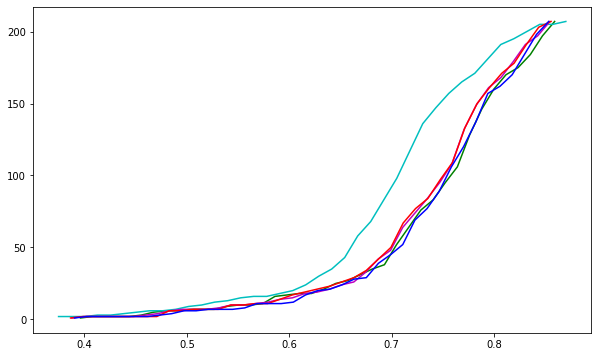

In [53]:
import matplotlib.pyplot as plt

# Plot
plt.figure()
plt.figure(figsize=(10,6))

values, base = np.histogram(mean_abs_err0, bins=40)
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative, c='g', label='FFMLP')

values, base = np.histogram(mean_abs_err1, bins=40)
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative, c='c', label='GRU 1 Layer')

values, base = np.histogram(mean_abs_err2, bins=40)
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative, c='m', label='GRU 2 Layer')

values, base = np.histogram(mean_abs_err3, bins=40)
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative, c='r', label='GRU 2 Layer 12 lag')

values, base = np.histogram(mean_abs_err4, bins=40)
cumulative = np.cumsum(values)
plt.plot(base[:-1], cumulative, c='b', label='GRU 2 Layer 64 lag')



plt.show()

In [0]:
# Rescale test & data
test_ups_pred0 = spd_scaler.inverse_transform(test_pred0)
test_ups_pred1 = spd_scaler.inverse_transform(test_pred1)
test_ups_pred2 = spd_scaler.inverse_transform(test_pred2)
test_ups_pred3 = spd_scaler.inverse_transform(test_pred3)
spd_mat_upscale = spd_scaler.inverse_transform(spd_mat)

<Figure size 432x288 with 0 Axes>

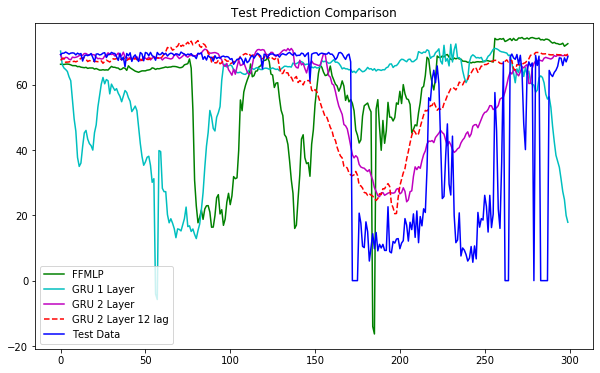

In [25]:
# Plot comparing predictions

import matplotlib.pyplot as plt

# Plot
plt.figure()
plt.figure(figsize=(10,6))

link = 96
plt.plot(test_ups_pred0[0:300,link], 'g', label='FFMLP')
plt.plot(test_ups_pred1[0:300,link], 'c', label='GRU 1 Layer')
plt.plot(test_ups_pred2[0:300,link], 'm', label='GRU 2 Layer')
plt.plot(test_ups_pred3[0:300,link], 'r--', label='GRU 2 Layer 12 lag')
plt.plot(spd_mat_upscale[30529+0:30529+300,link], 'b', label='Test Data')
plt.title('Test Prediction Comparison')
plt.legend()

plt.show()


## Other experiments using subsets of data

In [0]:
# Choosing a new subset of the sensors for testing model
#from google.colab import drive
#drive.mount('/content/gdrive')

sens_sub_dt = pd.read_csv('/content/gdrive/My Drive/NNDL-data/sensor-subset-downtown.csv')
#sens_sub = pd.read_csv('data/pems-m/sensor-subset.csv')

spd_mat_dt = np.zeros([df_LA.shape[0],sens_sub_dt.shape[0]])
for i in range(sens_sub_dt.shape[0]):
  spd_mat_dt[:,i] = np.array(df_LA[sens_sub_dt.iloc[i]['sensor_id'].astype(int).astype(str)])

print(spd_mat_dt.shape)

spd_scaler_dt = MinMaxScaler(feature_range=(0, 1))
spd_mat_dt = spd_scaler_dt.fit_transform(spd_mat_dt)

n_out_dt = spd_dt_mat.shape[-1]

(34272, 32)


In [0]:
from sklearn.metrics import mean_squared_error

gen_tes_dt = generator_mat(spd_mat_dt,lag=lag,ahead=ahead,
                   min_ind=30529,max_ind=None,step=step,batch_size=batch_size)

test_pred_dt = model.predict_generator(gen_tes_dt, steps=test_steps,verbose=1)
test_pred_dt = spd_scaler_dt.inverse_transform(test_pred_dt)
spd_mat_dt = spd_scaler_dt.inverse_transform(spd_mat_dt)

mean_squared_error(test_pred_dt, spd_mat_dt[30529:30529+3712,])

29/29 [==============================] - 0s 5ms/step


198.01816366386743

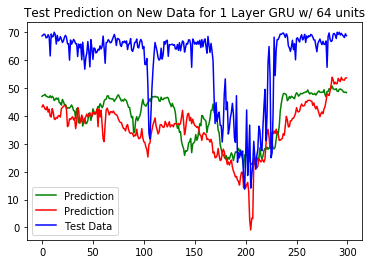

In [0]:
import matplotlib.pyplot as plt

plt.figure()

plt.plot(test_pred[0:300,30], 'g', label='Prediction')
plt.plot(test_pred_dt[0:300,30], 'r', label='Prediction')
plt.plot(spd_mat_dt[30529+0:30529+300,30], 'b', label='Test Data')
plt.title('Test Prediction on New Data for 1 Layer GRU w/ 64 units')
plt.legend()

plt.show()

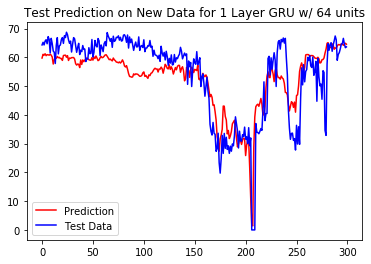

In [0]:
plt.plot(test_pred_dt[0:300,3], 'r', label='Prediction')
plt.plot(spd_mat_dt[30529+0:30529+300,3], 'b', label='Test Data')
plt.title('Test Prediction on New Data for 1 Layer GRU w/ 64 units')
plt.legend()

plt.show()